## Importing libraries and datasets

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

The datasets that will be imported are cleaned versions of the ones originally provided. Where with 'cleaned' we mean that half of the columns have been removed. However there is no substatial difference in the data contained. <br>
Additionally, we create a dummy for each dataset to signal which city it represents.

In [84]:
# Dataset is (75) 37 cols, I reset the max columns displayed
pd.set_option('display.max_columns', 37) 

ams = pd.read_csv("data/amsterdam.csv")
ams['Amsterdam'] = 1 
rott = pd.read_csv("data/rotterdam.csv")
rott['Rotterdam'] = 1
hague = pd.read_csv("data/hague.csv")
hague['Hague'] = 1

dfs = [ams, rott, hague]

for df in dfs: # price was a string variable
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)

hague = hague[hague['price']<30000] # outliers in the hague, avg price was like $10000 

df_tot = pd.concat([ams, rott, hague], axis = 0) #We concatenate the three datasets into a single one.

df_tot['Amsterdam'] = df_tot['Amsterdam'].fillna(0) # we fill with 0s the city dummies, so they are proper dummies
df_tot['Hague'] = df_tot['Hague'].fillna(0)
df_tot['Rotterdam'] = df_tot['Rotterdam'].fillna(0)

df_tot['n_amen'] = ams['amenities'].apply(len) # get number of amenities for the analysis
df_tot['ppp'] = df_tot['price']/df_tot['accommodates'] # get info about price per person
df_tot['host_is_superhost'] = df_tot['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
# recode superhost for future analyses

print(f"Dim AMS: {ams.shape}\nDim Rott:{rott.shape}\nDim Hague:{hague.shape}")


Dim AMS: (8945, 36)
Dim Rott:(1091, 34)
Dim Hague:(991, 36)


## Exploratory Data Analysis

Get summary statistics with the `describe` method.

In [ ]:
ams.describe

In [ ]:
rott.describe

In [ ]:
hague.describe

In [ ]:
df_tot.describe

#### Boxplot of the prices across cities

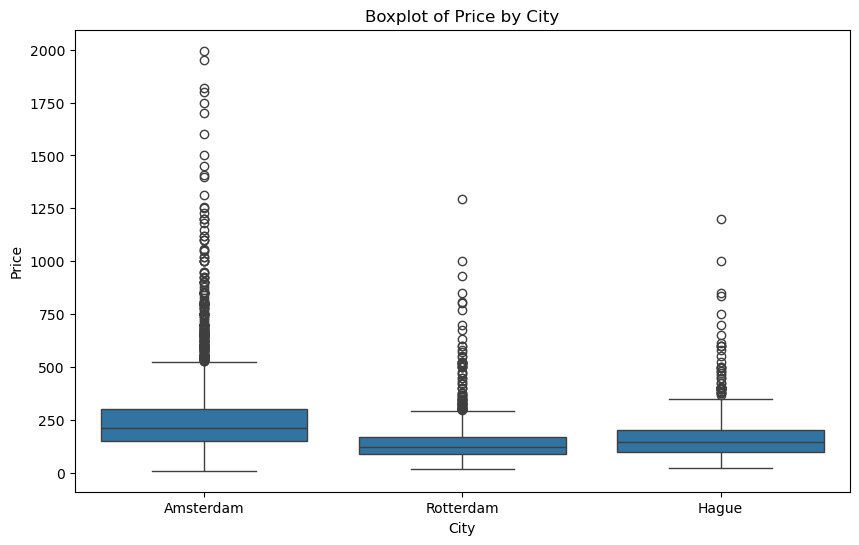

In [58]:
# Melt the DataFrame to long format
df_melted = df_tot.melt(id_vars=['price'], value_vars=['Amsterdam', 'Rotterdam', 'Hague'], 
                        var_name='city', value_name='is_city')
df_melted = df_melted[df_melted['price']<2000] # hard trim the outliers
df_melted = df_melted[df_melted['is_city'] == 1]  # keep only rows where is_city is 1

# Boxplotsss
plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='price', data=df_melted)
plt.title('Boxplot of Price by City')
plt.xlabel('City')
plt.ylabel('Price')
plt.show()

#### What variables are correlated with price?

In [59]:
num_var = df_tot.select_dtypes(include='number')
correlation_matrix = num_var.corr()

# Extract correlations for the 'price' column
price_correlation = correlation_matrix['price'].drop('price')

# Sort the correlations by absolute value in descending order
sorted_price_correlation = price_correlation.abs().sort_values(ascending=False)

print("Variables most correlated with price:")
print(sorted_price_correlation)

Variables most correlated with price:
ppp                            0.784979
accommodates                   0.345007
beds                           0.243865
Amsterdam                      0.186965
reviews_per_month              0.164352
number_of_reviews              0.148319
Rotterdam                      0.136112
review_scores_location         0.128643
review_scores_rating           0.124275
n_amen                         0.122901
Hague                          0.108517
review_scores_accuracy         0.088849
review_scores_communication    0.087407
availability_30                0.080759
availability_365               0.078772
review_scores_checkin          0.077386
id                             0.077299
review_scores_cleanliness      0.072000
maximum_nights                 0.058630
review_scores_value            0.057668
host_id                        0.039407
host_total_listings_count      0.032233
minimum_nights                 0.024876
Name: price, dtype: float64


<Axes: >

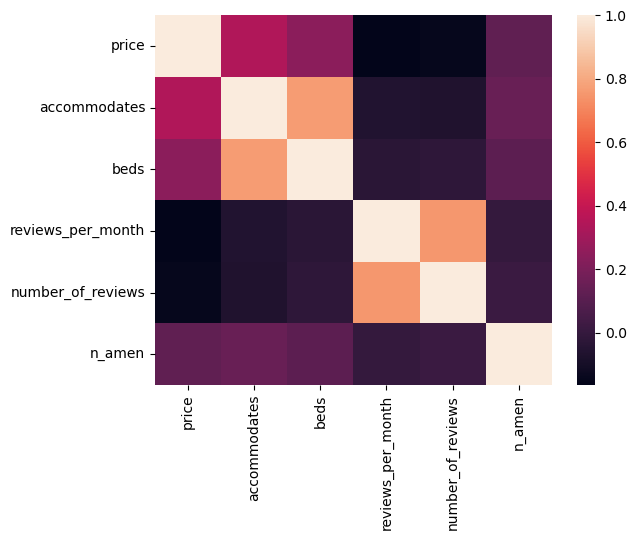

In [60]:
# Select specific columns
corr_df = df_tot[['price', 'accommodates', 'beds', 'reviews_per_month', 'number_of_reviews', 'n_amen']]
corr = corr_df.corr()
sns.heatmap(corr)

We can see that the variables mostly correlated with price are the *beds* and *accomodates*, which are fairly similar variables. Also, they are not really indicative of anything, since it's quite obvious that if in a house can stay more people, it will cost more (and those people will share the cost). <br>
Thus, we construct a variable `ppp`, indicating *price per person*, obtained by dividing `price` by `accomodates`.  <br>
All further analysis focusing on price will use this new variable.

In [64]:
ppp_correlation = correlation_matrix['ppp'].drop(['ppp','price'])

# Sort the correlations by absolute value in descending order
sorted_price_correlation = ppp_correlation.abs().sort_values(ascending=False)

print("Variables most correlated with price:")
print(sorted_price_correlation)

Variables most correlated with price:
Amsterdam                      0.216657
Hague                          0.145007
Rotterdam                      0.137731
availability_30                0.132940
review_scores_location         0.120180
number_of_reviews              0.120034
accommodates                   0.119899
reviews_per_month              0.119875
review_scores_rating           0.105947
beds                           0.094264
availability_365               0.090002
review_scores_cleanliness      0.088216
review_scores_accuracy         0.086468
review_scores_communication    0.076278
review_scores_checkin          0.068676
id                             0.064324
review_scores_value            0.055221
maximum_nights                 0.043127
host_total_listings_count      0.035992
host_id                        0.035353
n_amen                         0.031255
minimum_nights                 0.017882
Name: ppp, dtype: float64


These results are a bit more confusing: Amsterdam is the top correlated vaiables, hinting at higher prices for the Dutch capital. However, the other two cities follow. `review_scores_location` implies that better locations cost more: indeed, we theorize that the price is driven by location more than anything else. However there is still a (lower) correlation with `accomodates`. On the other hand, `n_amen` is now apparently irrelevant. 

#### What are the most reviewed neighborhoods?

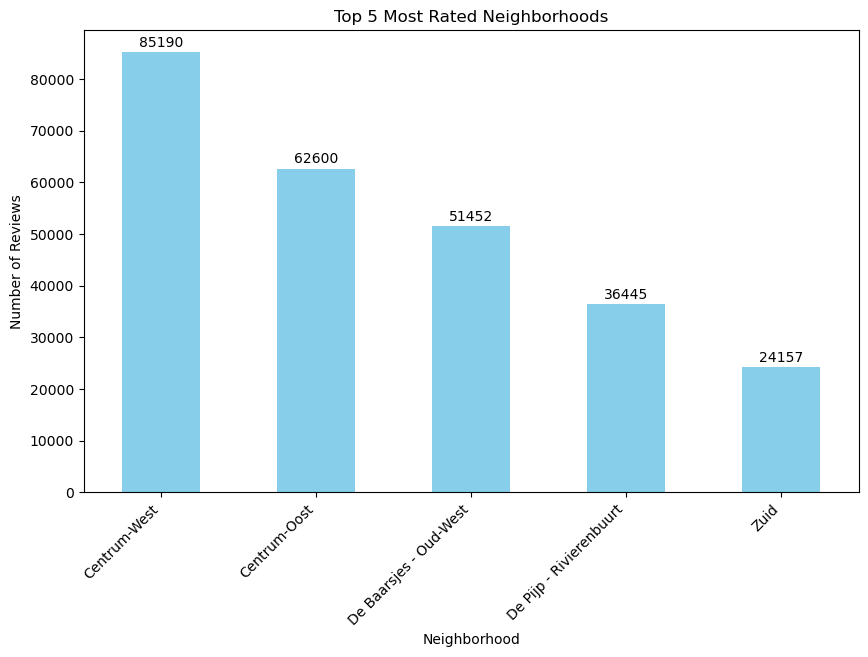

In [28]:
neigh_rev = df_tot.groupby('neighbourhood_cleansed')['number_of_reviews'].sum()
neigh_rev_sorted = neigh_rev.sort_values(ascending=False)

# 5 most reviewed neighborhoods
top_5_neigh = neigh_rev_sorted.head(5)

# Bar chart
plt.figure(figsize=(10, 6))
top_5_neigh.plot(kind='bar', color='skyblue')
plt.title('Top 5 Most Rated Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')

for index, value in enumerate(top_5_neigh): # put precise number on top of each bar
    plt.text(index, value + 500, str(value), ha='center', va='bottom')

plt.show()

## Quick interesting facts on the data

In [70]:
# How many hosts and properties we have?
unique_prop = df_tot['id'].nunique()
unique_hosts = df_tot['host_id'].nunique()

# When did the first host register to the AirBnB platform?
df_tot['host_since'] = pd.to_datetime(df_tot['host_since'])
oldest_host = df_tot['host_since'].min()
print(f"The 'oldest' host registerd on {oldest_host}\n")

# What is the property with the most reviews?
df_tot['number_of_reviews'].idxmax()
df_tot.iloc[3286]

# What is the house type with highest mean rating?
type_rating = df_tot.groupby('property_type')['review_scores_rating'].mean()
sorted_ratings = type_rating.sort_values(ascending=False)
print(f"Highest rated {sorted_ratings.head(5)}:\n") 
# this is not really explaining nothing, since we may have a single "Yurt" listing with a perfect rating

# What are the house types with the most reviews?
nrev_type = df_tot.groupby('property_type')['review_scores_rating'].count()
nrev_sorted = nrev_type.sort_values(ascending=False)
print(f"The number of reviews for each {nrev_sorted.head(5)}:\n")

# What is the average cost per person for each house type?
print(f"The avg price for each {df_tot.groupby('room_type')['ppp'].mean()}:")

The 'oldest' host registerd on 2008-09-24 00:00:00

Highest rated property_type
Yurt                        5.000000
Earthen home                5.000000
Private room                4.928333
Private room in bungalow    4.910000
Entire villa                4.896250
Name: review_scores_rating, dtype: float64:

The number of reviews for each property_type
Entire rental unit                   3834
Entire condo                         1689
Entire home                           909
Private room in rental unit           531
Private room in bed and breakfast     325
Name: review_scores_rating, dtype: int64:

The avg price for each room_type
Entire home/apt    88.075080
Hotel room         81.315000
Private room       62.128957
Shared room        47.091667
Name: ppp, dtype: float64:


In [37]:
# get neighbourhood dummies
print(f"Number of dimensions after neighborhood dummies:{df_tot.shape}") 
df_n = pd.get_dummies(df_tot, columns=['neighbourhood_cleansed'], prefix='')
print(f"Number of dimensions after neighborhood dummies: {df_n.shape}")

Number of dimensions after neighborhood dummies:(11027, 39)
Number of dimensions after neighborhood dummies: (11027, 222)


There are 183 total neighborhoods in our data. Adding a dummy for each may be a bit much, as we have just 11000 observations.

## Inferential statistics
We want to estimate how the number of amenities influences price.

We first implement a 'naive' regression of price on `n_amen`, `accomodates`, `review_scores_location`. <br>
We control for accomodates because we showed how the "size" of the house (obviously) influences price. Additionally, we use `review_score_location` as a proxy for the quality of the location. This will take into account the fact that houses in nicer locations will cost more, independently of the number of amenities.

In [78]:
# REGRESSION ON N_AMENITIES
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

df_tot.dropna(inplace=True)
X = df_tot[['n_amen', 'accommodates', 'review_scores_location']]
y = df_tot['price']
model = LinearRegression()
model.fit(X,y)

# Coefficients 
coefficients = model.coef_
intercept = model.intercept_

# other variables we like to see
r_squared = model.score(X, y)
print("R-squared:", r_squared)
predictions = model.predict(X)
residuals = y - predictions

# Mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)

# Summary statistics
import statsmodels.api as sm
X_sm = sm.add_constant(X)  # Add constant for intercept in statsmodels
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())

R-squared: 0.316776808907695
Mean Squared Error: 17288.520206256777
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     311.4
Date:                Thu, 27 Jun 2024   Prob (F-statistic):          4.24e-166
Time:                        19:01:08   Log-Likelihood:                -12715.
No. Observations:                2019   AIC:                         2.544e+04
Df Residuals:                    2015   BIC:                         2.546e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

We know implement a less naive regression, by including the city dummies and regressing on price.

In [92]:
X1 = df_tot[['n_amen', 'accommodates', 'review_scores_location', 'Amsterdam','Rotterdam','Hague','host_is_superhost']]
y1 = df_tot['price'] # with ppp we have 0.08 R2
df_cleaned = pd.concat([X1, y1], axis=1).dropna()
X1 = df_cleaned.drop(columns=['price'])
y1 = df_cleaned['price']

model.fit(X1,y1)

# Coefficients 
coefficients = model.coef_
intercept = model.intercept_

# other variables we like to see
r_squared = model.score(X1, y1)
print("R-squared:", r_squared)
predictions = model.predict(X1)
residuals = y1 - predictions

# Mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y1, predictions)
print("Mean Squared Error:", mse)

# Summary statistics
import statsmodels.api as sm
X1_sm = sm.add_constant(X1)  # Add constant for intercept in statsmodels
model_sm = sm.OLS(y1, X1_sm).fit()
print(model_sm.summary())


R-squared: 0.2007830797952821
Mean Squared Error: 30644.46417625057
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     271.0
Date:                Thu, 27 Jun 2024   Prob (F-statistic):          2.00e-310
Time:                        19:16:10   Log-Likelihood:                -42665.
No. Observations:                6480   AIC:                         8.534e+04
Df Residuals:                    6473   BIC:                         8.539e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

## Price prediction
We know attempt to develop a model that can predict price for each listing.


In [94]:
# TODO
# Decide whether to focus just on Amsterdam
# Divide train/test/validation
# Ridge regression with neighbourhood dummies
# 5 fold CV

### PCA and Clustering
For now this just focuses on Amsterdam's dataset

In [71]:
from sklearn.preprocessing import StandardScaler
ams_num = ams.select_dtypes(include='number')
ams_num = ams_num.dropna()
columns_to_drop = ['id', 'host_id', 'minimum_nights',
                  'maximum_nights','availability_365', 'Amsterdam']
ams_num.drop(columns=columns_to_drop, inplace=True)
# Assuming X is your dataset as a numpy array or pandas DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ams_num)

In [72]:
from sklearn.decomposition import PCA
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the scaled data
principal_components = pca.fit_transform(X_scaled)

# Extract the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_ratio}')

Explained variance ratio: [0.33341962 0.1506291 ]


In [73]:
loadings = pca.components_
# Get feature names
feature_names = ams_num.columns

# Print associated variables (features) with loadings
for i, pc in enumerate(loadings):
    print(f"\nPrincipal Component {i+1}:")
    for j, feature in enumerate(feature_names):
        print(f"{feature}: {pc[j]}")


Principal Component 1:
host_total_listings_count: -0.055862113192550224
accommodates: -0.015799806473012264
beds: -0.028491099790909725
price: 0.058388032246088704
availability_30: -0.06481443645748507
number_of_reviews: -0.027375932352602335
review_scores_rating: 0.41591392312823877
review_scores_accuracy: 0.4045129584755939
review_scores_cleanliness: 0.3565445190891357
review_scores_checkin: 0.36447049322004277
review_scores_communication: 0.3861069028206261
review_scores_location: 0.3056406143000746
review_scores_value: 0.38318423552818354
reviews_per_month: -0.03944349227426035

Principal Component 2:
host_total_listings_count: -0.02842036477617312
accommodates: 0.5547021541301951
beds: 0.512181444649266
price: 0.41223804860425095
availability_30: -0.024667482272047167
number_of_reviews: -0.35520841194322217
review_scores_rating: 0.01757869130768152
review_scores_accuracy: -0.006361375862799456
review_scores_cleanliness: -0.05156802947302801
review_scores_checkin: -0.0092706294192

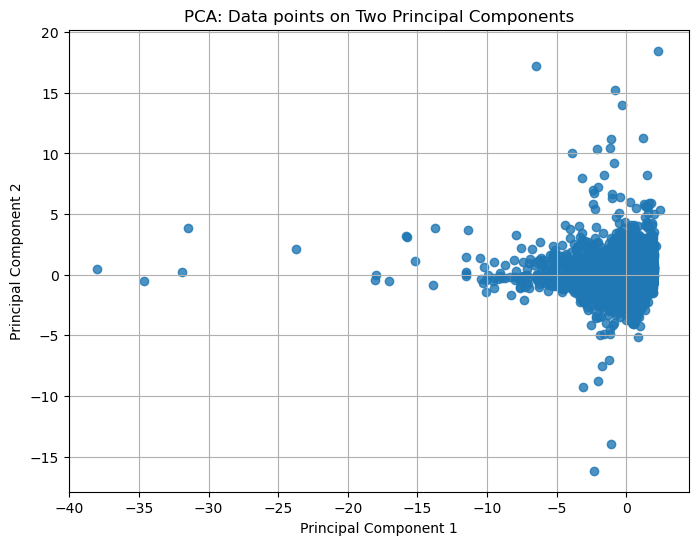

In [74]:
import matplotlib.pyplot as plt

# Plotting the principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.8)
plt.title('PCA: Data points on Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

We try to get rid of the outliers on the left to see how the plot is rescaled.

In [95]:
threshold = -20
filtered_indices = principal_components[:, 0] >= threshold

# Create filtered dataset
filtered_data = ams_num[filtered_indices]

# Check the shape of filtered data
print("Shape of filtered data:", filtered_data.shape)

Shape of filtered data: (4797, 14)


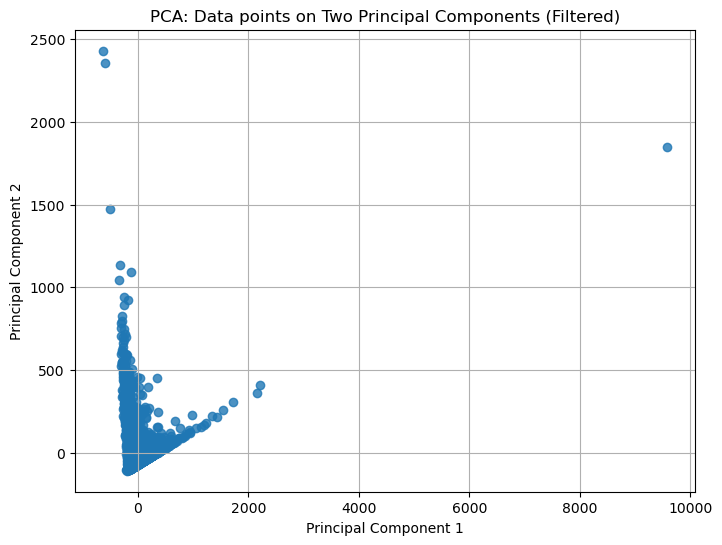

In [96]:
import matplotlib.pyplot as plt

# Perform PCA on the filtered data
pca_filtered = PCA(n_components=2)
principal_components_filtered = pca_filtered.fit_transform(filtered_data)

# Plotting the principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_filtered[:, 0], principal_components_filtered[:, 1], alpha=0.8)
plt.title('PCA: Data points on Two Principal Components (Filtered)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Very bad. We conclude no clustering.